<a href="https://colab.research.google.com/github/emarkou/multilingual-bert-text-classification/blob/master/mBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [4]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers import get_linear_schedule_with_warmup

In [5]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Tesla T4


In [7]:
MAX_LEN = 128 # max sequences length
batch_size = 32

In [25]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

labels_encoding = {
    "neg": 0,
    "neutral": 1,
    "pos": 2
}

def preprocessing(df):
    sentences = df.text.values
    labels = np.array([labels_encoding[l] for l in df.target.values])

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = MAX_LEN
                    )

        encoded_sentences.append(encoded_sent)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")
    return encoded_sentences, labels

def attention_masks(encoded_sentences):
    # attention masks, 0 for padding, 1 for actual token
    attention_masks = []
    for sent in encoded_sentences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [26]:
# load the datasets
df = pd.read_csv("training_data-cy.csv")
df_test = pd.read_csv("testing_data.csv")

In [27]:
df.head()


,text,target
0,శ్రీలంకలో ఉగ్రదాడుల దృష్ట్యా అప్రమత్తంగా ఉండాల...,neutral
1,"ఒక్కొక్కరిని‌ 20 లక్షలు అడిగారని, సుపుత్రుడి ద...",neg
2,ఈయన గారికి కూడా తెలంగాణపై చాలా ఆశలు వున్నాయి,neutral
3,బాలికలకు రూ:2250 నుంచి రూ 3000లకు పెంచారు.\n,neutral
4,ఆయా శాఖ అధికారులతో తక్షణమే నివేదిక తెప్పించుకొ...,pos


In [28]:
print(df.columns)


Index(['text', 'target'], dtype='object')


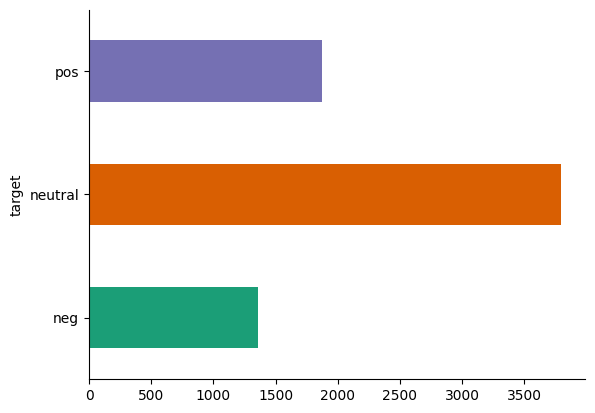

In [29]:
# @title target

from matplotlib import pyplot as plt
import seaborn as sns
df_test.groupby('target').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [30]:
train_encoded_sentences, train_labels = preprocessing(df)
train_attention_masks = attention_masks(train_encoded_sentences)

test_encoded_sentences, test_labels = preprocessing(df_test)
test_attention_masks = attention_masks(test_encoded_sentences)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [31]:
train_inputs = torch.tensor(train_encoded_sentences)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(test_encoded_sentences)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_attention_masks)

In [32]:
# data loader for training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# data loader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [33]:

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8,
                  weight_decay = 0.01
                )

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p==l)/len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step%10 == 0:
                elapsed = time.time()-start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            # input_data, input_masks, input_labels = batch
            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            # forward propagation
            out = model(input_data,
                        token_type_ids = None,
                        attention_mask = input_masks,
                        labels = input_labels)

            loss = out[0]
            total_loss = total_loss + loss.item()

            # backward propagation
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), 1)

            optimizer.step()

        epoch_loss = total_loss/len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time()-start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0,0
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids = None,
                            attention_mask=eval_masks)
            logits = out[0]

            #  Uncomment for GPU execution
            logits = logits.detach().cpu().numpy()
            eval_labels = eval_labels.to('cpu').numpy()
            batch_acc = compute_accuracy(logits, eval_labels)

            # Uncomment for CPU execution
            # batch_acc = compute_accuracy(logits.numpy(), eval_labels.numpy())

            eval_acc += batch_acc
        print(f"Accuracy: {eval_acc/(step+1)}, Time elapsed: {time.time()-start_validation_time}")
    return losses


In [35]:
losses = run_train(epochs)

======== Epoch 1 / 3 ========
0/879 --> Time elapsed 0.017926931381225586


<ipython-input-34-9f0abb8962ef>:40: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1)


10/879 --> Time elapsed 7.887867212295532
20/879 --> Time elapsed 14.65436315536499
30/879 --> Time elapsed 21.530049562454224
40/879 --> Time elapsed 28.5570387840271
50/879 --> Time elapsed 35.795330286026
60/879 --> Time elapsed 43.180909872055054
70/879 --> Time elapsed 50.59450340270996
80/879 --> Time elapsed 57.82962369918823
90/879 --> Time elapsed 64.95918321609497
100/879 --> Time elapsed 71.97272062301636
110/879 --> Time elapsed 78.9065055847168
120/879 --> Time elapsed 85.8390257358551
130/879 --> Time elapsed 92.7701370716095
140/879 --> Time elapsed 99.72944593429565
150/879 --> Time elapsed 106.73226928710938
160/879 --> Time elapsed 113.81385517120361
170/879 --> Time elapsed 120.9555344581604
180/879 --> Time elapsed 128.11032152175903
190/879 --> Time elapsed 135.28719997406006
200/879 --> Time elapsed 142.42944240570068
210/879 --> Time elapsed 149.53717279434204
220/879 --> Time elapsed 156.60632848739624
230/879 --> Time elapsed 163.64754581451416
240/879 --> Time

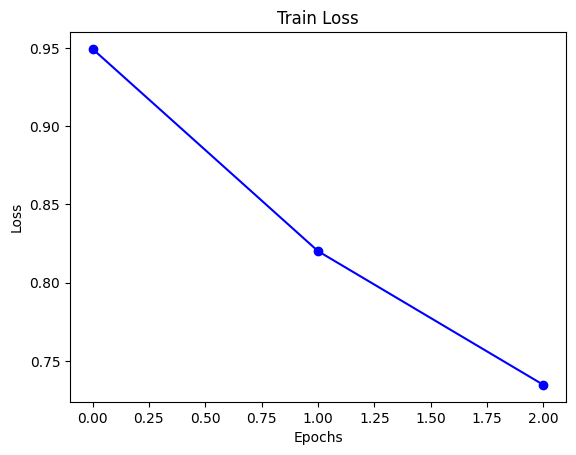

In [37]:
 # plot losses
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [40]:
def run_test(df_test):

    test_encoded_sentences, test_labels = preprocessing(df_test)
    test_attention_masks = attention_masks(test_encoded_sentences)

    test_inputs = torch.tensor(test_encoded_sentences)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_attention_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    eval_loss, eval_acc = 0,0
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids = None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc
    print(f"Accuracy: {eval_acc/(step+1)}")

In [41]:
run_test(df_test)

Accuracy: 0.6514001623376624
